In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle # para leer los archivos comprimidos (.p)

#parameters#####################
nsensores =4 # 1 a 4
SampleFreq=2000
archivoLectura = './mediciones/de11_1.p' #'./datos/3sens_130423_2.p' #  './datos/oclusion_bien.p'
#archivoLectura = '.\oclusion_bien.p'
#archivoLectura = '.\dc2min.p'

#############################

def leer_datos(nombreArchivo):
    with open(nombreArchivo, 'rb') as f:
        datos = pickle.load(f)
        print("Datos extraidos de %s" %nombreArchivo)
        f.close()
    return datos

samples = leer_datos(archivoLectura)
#samples_sensor0 = samples['sensor0']
#samples_sensor1 = samples['sensor1']
samples_sensor0 = samples['sensor0']
if nsensores >= 2 :
    samples_sensor1 = samples['sensor1']
if nsensores >= 3 :
    samples_sensor2 = samples['sensor2']
if nsensores >= 4 :
    samples_sensor3 = samples['sensor3']

cantidad_samples = len(samples_sensor0) #1.5*60*2000 #min*60*fsamp


Datos extraidos de ./mediciones/de11_1.p


<IPython.core.display.Javascript object>


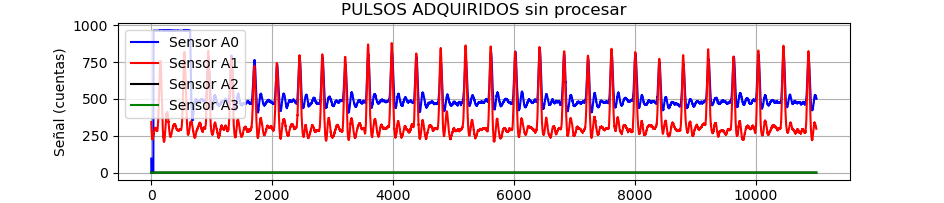

<IPython.core.display.Javascript object>


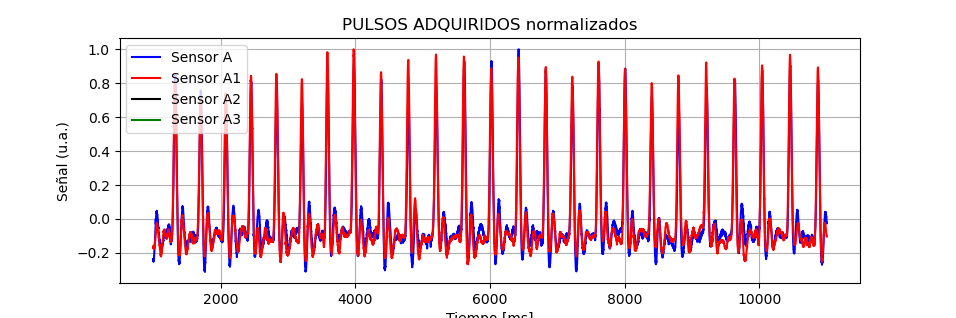

C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_6512\1691291397.py:57: RuntimeWarning: invalid value encountered in true_divide
  samples_sensor2 /= np.max(samples_sensor2)
C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_6512\1691291397.py:63: RuntimeWarning: invalid value encountered in true_divide
  samples_sensor3 /= np.max(samples_sensor3)


In [14]:
#preprocesamiento: normalizo señales
%matplotlib notebook
SampleFreqKHz = SampleFreq/1000
time = np.arange(0,cantidad_samples/SampleFreqKHz,1/SampleFreqKHz)
#time = np.linspace(0,samples_sensor0[250:].size/100,samples_sensor0[250:].size)

# grafico de muestras completas
fig = plt.figure()
plt.plot(time,samples_sensor0, 'b', label="Sensor A0")
#plt.plot(time,samples_sensor1, 'r', label="Sensor B")
if nsensores >= 2 :
    plt.plot(time,samples_sensor1, 'r', label="Sensor A1")
if nsensores >= 3 :
    plt.plot(time,samples_sensor2, 'k', label="Sensor A2")
if nsensores >= 4 :
    plt.plot(time,samples_sensor3, 'g', label="Sensor A3")
    
plt.xlabel("Tiempo [ms]")
plt.ylabel("Señal (cuentas)")
plt.title("PULSOS ADQUIRIDOS sin procesar")
plt.legend()
plt.grid()
plt.show()
######################################################################

#descarto primeras muestras
t_sec_discarded = 1 
n_discarded = round(t_sec_discarded*SampleFreq) #
samples_sensor0 = samples_sensor0[n_discarded:] 
time = time[n_discarded:] 
if nsensores >= 2 :
    samples_sensor1 = samples_sensor1[n_discarded:] 
if nsensores >= 3 :
    samples_sensor2 = samples_sensor2[n_discarded:] 
if nsensores >= 4 :
    samples_sensor3 = samples_sensor3[n_discarded:] 


# normalizo los datos.
# resto el valor medio a mis datos
# obtengo valor maximo de cada señal y divido con respecto a ese valor
samples_sensor0 -= np.mean(samples_sensor0)
samples_sensor0 /= np.max(samples_sensor0)
#samples_sensor0 -= .5
#samples_sensor0 /= .5

fig = plt.figure()
plt.plot(time,samples_sensor0, 'b', label="Sensor A")
if nsensores >= 2 :
    samples_sensor1 -= np.mean(samples_sensor1)
    samples_sensor1 /= np.max(samples_sensor1)
    #samples_sensor1 -= .5
    #samples_sensor1 /= .5
    plt.plot(time,samples_sensor1, 'r', label="Sensor A1")
if nsensores >= 3 :
    samples_sensor2 -= np.mean(samples_sensor2)
    samples_sensor2 /= np.max(samples_sensor2)
    #samples_sensor2 -= .5
    #samples_sensor2 /= .5
    plt.plot(time,samples_sensor2, 'k', label="Sensor A2")
if nsensores >= 4 :
    samples_sensor3 -= np.mean(samples_sensor3)
    samples_sensor3 /= np.max(samples_sensor3)
    #samples_sensor3 -= .5
    #samples_sensor3 /= .5
    plt.plot(time,samples_sensor3, 'g', label="Sensor A3")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Señal (u.a.)")
plt.title("PULSOS ADQUIRIDOS normalizados")
plt.legend()
plt.grid()
plt.show()

discarded peak nr 1 at 1.0785 for signal 1 (peak at signal0 was at 1.457 >100ms after beat at signal1)
discarded peak nr 2 at 1.457 for signal 0 (peak at signal1 was at 1.829 >100ms after beat at signal0)
discarded peak nr 3 at 1.829 for signal 1 (peak at signal0 was at 2.2105 >100ms after beat at signal1)
discarded peak nr 4 at 2.2105 for signal 0 (peak at signal1 was at 2.9765 >100ms after beat at signal0)
discarded peak nr 6 at 3.789 for signal 0 (peak at signal1 was at 4.1985 >100ms after beat at signal0)
discarded peak nr 7 at 4.1985 for signal 1 (peak at signal0 was at 4.6185 >100ms after beat at signal1)
discarded peak nr 8 at 4.6185 for signal 0 (peak at signal1 was at 5.4215 >100ms after beat at signal0)


<IPython.core.display.Javascript object>


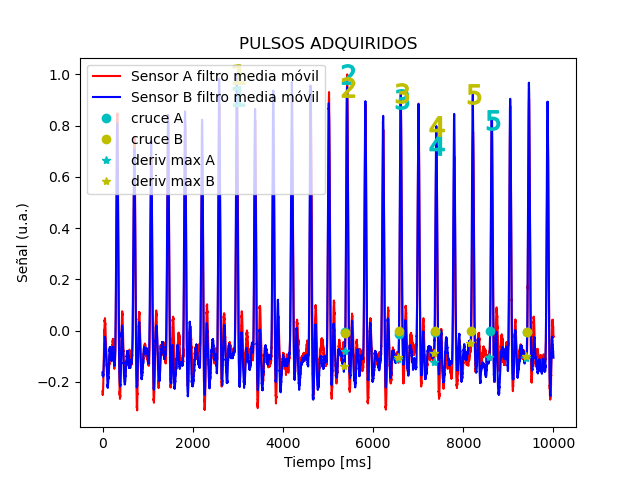

<IPython.core.display.Javascript object>


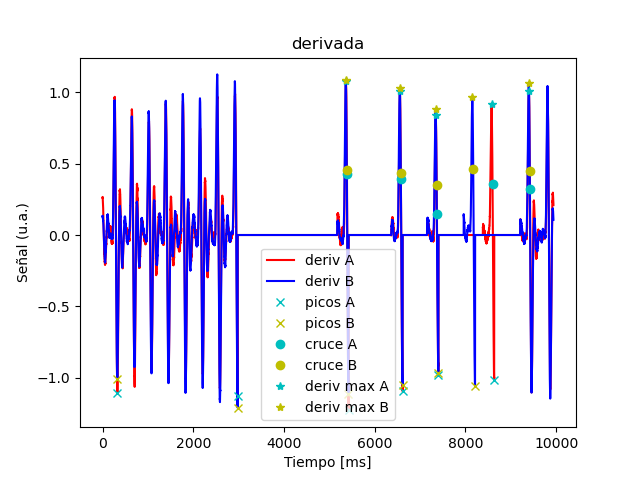

<IPython.core.display.Javascript object>


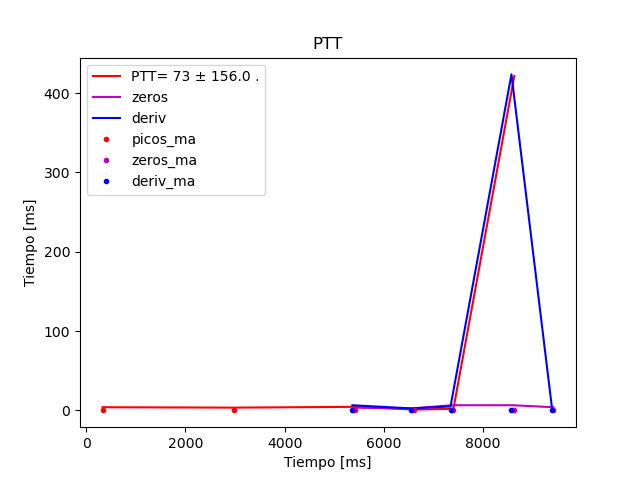

<IPython.core.display.Javascript object>


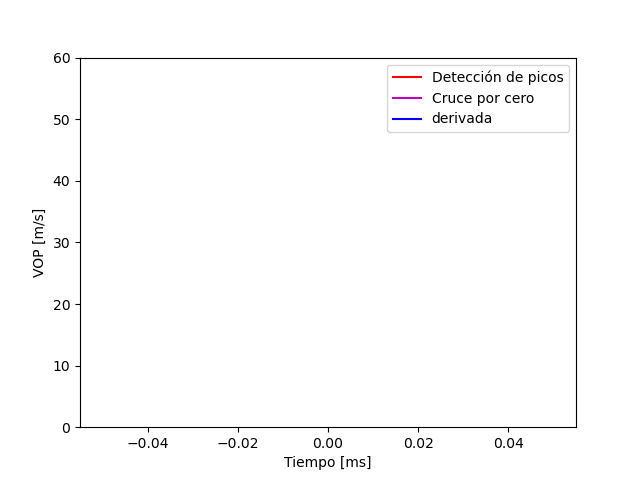

C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_6512\1420675011.py:300: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(time_ms[peaks0_ma],                   DISTANCIA_mts*1000/delta_T_ma_ma,    'r-', label='Detección de picos')    #  ptt con media movil
C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_6512\1420675011.py:301: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(time_ms[last_zeros_crossing_array0],  DISTANCIA_mts*1000/delta_T_zeros_ma, 'm-', label='Cruce por cero')   #  ptt detectada con cruce por cero
C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_6512\1420675011.py:302: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(time_ms[deriv_max_array0],            DISTANCIA_mts*1000/delta_T_deriv_ma, 'b-', label='derivada')      #  ptt detectada con reconstrucción derivada


<IPython.core.display.Javascript object>


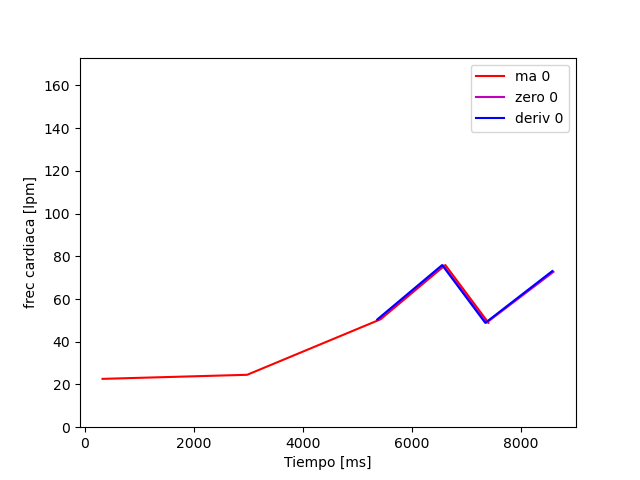

(0.0, 173.0)

In [35]:
#aplico filtro media movil, detecto picos, descarto picos sin pareja
#buscamos cruce por cero, derivada
#descarto latidos borde
#calculo delta_T de diferentes maneras
#calculo frec de diferentes maneras
#aplico filtro media movil a delta T
#calculo VOP
#grafico

#DISTANCIA_mts=0.36 #0.36 .04y 0.08 # VOP VELOCIDAD DE ONDA DE PULSO--------------

DISTANCIA_mts=0.47 #.47 codo punta dedo// 0.26codo muñeca // .21 muñeca punta dedo dedo a dedod .055 #0.36 .04y 0.08 # VOP VELOCIDAD DE ONDA DE PULSO--------------


"""
# FILTRO MEDIA MOVIL señal original ---------------------------------------------------------------------------------------------------
arr = new_samples_sensor0
window_size = 10 #10 ok 30 saca 50hz, menos quiza tambien
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    # Calculate the average of current window
    window_average = round(np.sum(arr[
        i:i+window_size]) / window_size, 2)
    # Store the average of current window in moving average list
    moving_averages.append(window_average)
    i += 1 # Shift window to right by one position
new_samples_sensor0_ma = np.array(moving_averages)
   
#------------------------------------------------   
arr = new_samples_sensor1
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    # Calculate the average of current window
    window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
    # Store the average of current # window in moving average list
    moving_averages.append(window_average)
    i += 1# Shift window to right by one position
new_samples_sensor1_ma = np.array(moving_averages)
"""
new_samples_sensor0_ma = new_samples_sensor0
new_samples_sensor1_ma = new_samples_sensor1
#DETECTOR DE PICOS-------------------------------------------------------------------------------------------------------
from scipy.signal import find_peaks
peaks0, _ = find_peaks(new_samples_sensor0, distance=900,height=0.1)
peaks1, _ = find_peaks(new_samples_sensor1, distance=900,height=0.1)# rojo

# DETECTOR DE PICOS sobre la señal con filtrada CON MEDIA MÓVIL
peaks0_ma, _ = find_peaks(new_samples_sensor0_ma, distance=900,height=0.1)
peaks1_ma, _ = find_peaks(new_samples_sensor1_ma, distance=900,height=0.1)# rojo


#discard peaks with no matching peak at both signals (when difference is greater than 100ms)
       
i = 0
for j in range(1,min(len(peaks1_ma),len(peaks0_ma))):
    i = i+1
    if abs(peaks0_ma[i] - peaks1_ma[i])/SampleFreqKHz > 100: #peak1 with beat, peak0 no beat 
        if peaks0_ma[i] < peaks1_ma[i]:
            print("discarded peak nr "+str(j)+" at "+str(peaks0_ma[i]/SampleFreq)+" for signal 0 (peak at signal1 was at "+str(peaks1_ma[i]/SampleFreq)+" >100ms after beat at signal0)")
            peaks0_ma[i:-1] = peaks0_ma[i+1:] #discard beat with no matching beat
            peaks0_ma = peaks0_ma[:-1] #and discard last beat (repeated)
        else :
            print("discarded peak nr "+str(j)+" at "+str(peaks1_ma[i]/SampleFreq)+" for signal 1 (peak at signal0 was at "+str(peaks0_ma[i]/SampleFreq)+" >100ms after beat at signal1)")
            peaks1_ma[i:-1] = peaks1_ma[i+1:] #discard beat with no matching beat
            peaks1_ma = peaks1_ma[:-1] #and discard last beat (repeated), achico array
        i = i-1 #dont increase beat if theres no match
   
    
    """
    if (peaks0_ma[i] - peaks1_ma[i])/SampleFreqKHz > 100: #peak1 with beat, peak0 no beat 
        print("discarded peak nr "+str(j)+" at "+str(peaks1_ma[i])+" for signal 1 (beat at signal0 was >100ms after beat at signal1)")
        peaks1_ma[i:-1] = peaks1_ma[i+1:] #discard beat with no matching beat
        #i = i-1 #dont increase beat if theres no match
        peaks1_ma = peaks1_ma[:-1] #discard last beat, achico array
    if (peaks1_ma[i] - peaks0_ma[i])/SampleFreqKHz > 100:  #peak0 with beat, peak1 no beat 
        #peaks0 = peaks0[1:] 
        print("discarded peak nr "+str(j)+" at "+str(peaks0_ma[i])+" for signal 0 (beat at signal1 was >100ms after beat at signal0)")
        peaks0_ma[i:-1] = peaks0_ma[i+1:] #discard beat with no matching beat
        peaks0_ma = peaks0_ma[:-1] #discard last beat, achico array
        #i = i-1
"""
   
#-buscamos cruce por cero-----------------------------------------------------------------------
last_zeros_crossing_array0 = np.zeros(len(peaks0_ma)-2);
len_beat_prev = peaks0_ma[1];
for n_beat in range(1,len(peaks0_ma)-1):
    latido = new_samples_sensor0_ma[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]] 
    zero_crossings = np.where(np.diff(np.sign(latido)))[0]
    if len(zero_crossings) > 0:
        last_zeros_crossing_array0[n_beat-1] = int(len_beat_prev + zero_crossings[-1])
    len_beat_prev = len_beat_prev + len(latido)
last_zeros_crossing_array0 = last_zeros_crossing_array0.astype(int)

last_zeros_crossing_array1 = np.zeros(len(peaks1_ma)-2);
len_beat_prev = peaks1_ma[1];
for n_beat in range(1,len(peaks1_ma)-1):
    latido = new_samples_sensor1_ma[peaks1_ma[n_beat]:peaks1_ma[n_beat+1]]   
    zero_crossings = np.where(np.diff(np.sign(latido)))[0]
    if len(zero_crossings) > 0:
        last_zeros_crossing_array1[n_beat-1] = int(len_beat_prev + zero_crossings[-1])
    len_beat_prev = len_beat_prev + len(latido)
last_zeros_crossing_array1 = last_zeros_crossing_array1.astype(int)

# calculamos derivada #####
#frac_time_deriv = 33 #porcentaje de la duracion del latido donde busco maxima derivada 
deriv_window_time_ms = 250
#/SampleFreq
#500/SampleFreq = deriv_window_time_ms/1000
#500/2000 = 0.25 = 250ms
#= deriv_window_time*/SampleFreq

2000
n_deriv_samples = 120 #14.9 50, 15 70, 12.3 100, 11.7 110, 9.7 115, 8.8 120, 11.5 130, 11.3 150,11.6 170, 11.2 200, 17.2 250 
deriv0 =  new_samples_sensor0_ma[n_deriv_samples:] - new_samples_sensor0_ma[:-n_deriv_samples]
# buscamos el max dentro de cada latido #####
deriv_max_array0 = np.zeros(len(peaks0_ma)-2);
len_beat_prev = peaks0_ma[1];
for n_beat in range(1,len(peaks0_ma)-1):
    latido_len = len(deriv0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]])
    #buscar maxima derivada desde el pico de ppg  y la mitad del latido
    deriv0[peaks0_ma[n_beat]+1:peaks0_ma[n_beat+1]-round(deriv_window_time_ms/1000*SampleFreq)] = 0
#    deriv0[peaks0_ma[n_beat]+1:round((peaks0_ma[n_beat]+peaks0_ma[n_beat+1])/frac_time_deriv+200)] = 0
    latido_deriv = deriv0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]] 
    deriv_max0 = np.argmax(latido_deriv)
    deriv_max_array0[n_beat-1] = int(len_beat_prev + deriv_max0)
    len_beat_prev = len_beat_prev + latido_len
deriv_max_array0 = deriv_max_array0.astype(int)

deriv1 =  new_samples_sensor1_ma[n_deriv_samples:] - new_samples_sensor1_ma[:-n_deriv_samples]
deriv_max_array1 = np.zeros(len(peaks1_ma)-2);
len_beat_prev = peaks1_ma[1];
for n_beat in range(1,len(peaks1_ma)-1):
    latido_len = len(deriv1[peaks1_ma[n_beat]:peaks1_ma[n_beat+1]])
    deriv1[peaks1_ma[n_beat]+1:peaks1_ma[n_beat+1]-round(deriv_window_time_ms/1000*SampleFreq)] = 0
#    deriv1[peaks1_ma[n_beat]+1:round((peaks1_ma[n_beat]+peaks1_ma[n_beat+1])/frac_time_deriv+200)] = 0
    latido_deriv = deriv1[peaks1_ma[n_beat]:peaks1_ma[n_beat+1]] 
    deriv_max1 = np.argmax(latido_deriv)
    deriv_max_array1[n_beat-1] = int(len_beat_prev + deriv_max1)
    len_beat_prev = len_beat_prev + latido_len
deriv_max_array1 = deriv_max_array1.astype(int)

    
#corrijo indices para que todos los vectores tengasn la misma longitud#################
len0 = min(len(peaks1),len(peaks0),len(peaks1_ma),len(peaks0_ma)) - 1
#len0 = min(len(peaks1),len(peaks0))
peaks0 = peaks0[:len0]
peaks1 = peaks1[:len0]
#len0 = min(len(peaks1_ma),len(peaks0_ma))
peaks0_ma = peaks0_ma[:len0]
peaks1_ma = peaks1_ma[:len0]

len0 = min(len(last_zeros_crossing_array0),len(last_zeros_crossing_array1))
last_zeros_crossing_array0 = last_zeros_crossing_array0[:len0]
last_zeros_crossing_array1 = last_zeros_crossing_array1[:len0]

len0 = min(len(deriv_max_array0),len(deriv_max_array1))
deriv_max_array0 = deriv_max_array0[:len0]
deriv_max_array1 = deriv_max_array1[:len0]


# CUENTO LATIDOS frec cardiaca---------------------------------------------------------------------------------------------------------
heart_period_samples = abs(peaks1[:-1] - peaks1[1:])
heart_period_ms = heart_period_samples/SampleFreqKHz #conivierto muestras a tiempo
frec0 = 60*1000/heart_period_ms #convierto ms a minutos

heart_period_samples_ma = abs(peaks0_ma[:-1] - peaks0_ma[1:])
heart_period_ms_ma  = heart_period_samples_ma /SampleFreqKHz #conivierto muestras a tiempo
frec0_ma  = 60*1000/heart_period_ms_ma  #convierto ms a minutos

heart_period_samples_ma = abs(last_zeros_crossing_array0[:-1] - last_zeros_crossing_array0[1:])
heart_period_ms_ma  = heart_period_samples_ma /SampleFreqKHz #conivierto muestras a tiempo
frec0_zero_ma  = 60*1000/heart_period_ms_ma  #convierto ms a minutos

heart_period_samples_ma = abs(deriv_max_array0[:-1] - deriv_max_array0[1:])
heart_period_ms_ma  = heart_period_samples_ma /SampleFreqKHz #conivierto muestras a tiempo
frec0_deriv_ma  = 60*1000/heart_period_ms_ma  #convierto ms a minutos



# PULSE TRANSIT TIME ----PTT---------------------------------------------------------------------------------------------
#calculo delta T ############
delta_T = (peaks0 - peaks1)/SampleFreqKHz
delta_T_ma = (peaks0_ma - peaks1_ma)/SampleFreqKHz
delta_T_zeros = (last_zeros_crossing_array0 - last_zeros_crossing_array1)/SampleFreqKHz
delta_T_deriv = (deriv_max_array0 - deriv_max_array1)/SampleFreqKHz

#discard delta_T higher than 100ms (found beat on one signal but not in the other)
for n_beat in range(2,len(delta_T_zeros)-1):
    if delta_T_zeros[n_beat] > 100:
        delta_T_zeros[n_beat] = delta_T_zeros[n_beat-1]

 #porque no lo hacemos en el resto de los arrays???       
        
# FILTRO MEDIA MOVIL a deltaT ---------------------------------------------------------------------------------------------------
delta_T_ma_ma = np.zeros(len(peaks0_ma))
arr = delta_T_ma
window_size = 10
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
    moving_averages.append(window_average)
    i += 1# Shift window to right by one position
delta_T_ma_ma[round(window_size/2)-1:-round(window_size/2)] =  np.array(moving_averages)

# FILTRO MEDIA MOVIL ---------------------------------------------------------------------------------------------------
delta_T_zeros_ma = np.zeros(len(delta_T_zeros))
arr = delta_T_zeros
window_size = 10
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
    moving_averages.append(window_average)
    i += 1# Shift window to right by one position
delta_T_zeros_ma[round(window_size/2)-1:-round(window_size/2)] =  np.array(moving_averages)


# FILTRO MEDIA MOVIL ---------------------------------------------------------------------------------------------------
delta_T_deriv_ma = np.zeros(len(delta_T_deriv))
arr = delta_T_deriv
window_size = 10
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
    moving_averages.append(window_average)
    i += 1# Shift window to right by one position
delta_T_deriv_ma[round(window_size/2)-1:-round(window_size/2)] =  np.array(moving_averages)


#####################3

SampleFreqKHz=SampleFreq/1000
time_ms = np.arange(0,cantidad_samples/SampleFreqKHz,1/SampleFreqKHz)

#plot señal original
fig = plt.figure(5)
#plt.plot(new_samples_sensor0, 'b-', label="Sensor A") #Señal original
#plt.plot(new_samples_sensor1, 'r-', label="Sensor B") #Señal original
#plt.plot(peaks0, new_samples_sensor0[peaks0], "xb")   #picos original
#plt.plot(peaks1, new_samples_sensor1[peaks1], "xr")   #picos original
plt.xlabel("Tiempo [ms]")
plt.ylabel("Señal (u.a.)")
plt.title("PULSOS ADQUIRIDOS")
plt.plot(time_ms[:len(new_samples_sensor0_ma)], new_samples_sensor0_ma, 'r-', label="Sensor A filtro media móvil" )
plt.plot(time_ms[:len(new_samples_sensor0_ma)], new_samples_sensor1_ma, 'b-', label="Sensor B filtro media móvil")
#plt.plot(time_ms[peaks0_ma],                  new_samples_sensor0_ma[peaks0_ma], "xc", label="picos A")
#plt.plot(time_ms[peaks1_ma],                  new_samples_sensor1_ma[peaks1_ma], "xy", label="picos B")
plt.plot(time_ms[last_zeros_crossing_array0], new_samples_sensor0_ma[last_zeros_crossing_array0], 'co', label="cruce A")
plt.plot(time_ms[last_zeros_crossing_array1], new_samples_sensor1_ma[last_zeros_crossing_array1], 'yo', label="cruce B")
plt.plot(time_ms[deriv_max_array0],           new_samples_sensor0[deriv_max_array0], "*c", label="deriv max A")
plt.plot(time_ms[deriv_max_array1],           new_samples_sensor1[deriv_max_array1], "*y", label="deriv max B")
plt.legend()

for i in range(1,len(peaks0_ma)):
    plt.plot(time_ms[peaks0_ma[i]],                  new_samples_sensor0_ma[peaks0_ma[i]], markersize=14, color="c", marker='$'+str(i)+'$', label="picos A")
    plt.plot(time_ms[peaks1_ma[i]],                  new_samples_sensor1_ma[peaks1_ma[i]], markersize=14, color="y",marker='$'+str(i)+'$', label="picos A")


#plot deriv
fig = plt.figure(11)
plt.title("derivada")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Señal (u.a.)")
plt.plot(time_ms[:len(deriv0)], deriv0, 'r-', label="deriv A")
plt.plot(time_ms[:len(deriv0)], deriv1, 'b-', label="deriv B")
plt.plot(time_ms[peaks0_ma],                  deriv0[peaks0_ma], "xc", label="picos A")
plt.plot(time_ms[peaks1_ma],                  deriv1[peaks1_ma], "xy", label="picos B")
plt.plot(time_ms[last_zeros_crossing_array0], deriv0[last_zeros_crossing_array0], "oc", label="cruce A")
plt.plot(time_ms[last_zeros_crossing_array1], deriv1[last_zeros_crossing_array1], "oy", label="cruce B")
plt.plot(time_ms[deriv_max_array0],           deriv0[deriv_max_array0], 'c*', label="deriv max A")
plt.plot(time_ms[deriv_max_array1],           deriv1[deriv_max_array1], 'y*', label="deriv max B")
plt.legend()


fig = plt.figure(8)
plt.title("PTT")
plt.ylabel("Tiempo [ms]")
plt.xlabel("Tiempo [ms]")
#plt.plot(delta_T, 'c-', label="cruce A")
mean = np.mean(delta_T_ma)
std = np.std(delta_T_ma)
myorder = "PTT= {:.0f} ± {:.1f} ."

plt.plot(time_ms[peaks0_ma],                   delta_T_ma, 'r-', markersize=2, label= myorder.format(mean, std))
plt.plot(time_ms[last_zeros_crossing_array0],  delta_T_zeros, 'm-', markersize=2, label="zeros")
plt.plot(time_ms[deriv_max_array0],            delta_T_deriv, 'b-', markersize=2, label="deriv")
plt.plot(time_ms[peaks0_ma],                   delta_T_ma_ma, 'r.', label="picos_ma")
plt.plot(time_ms[last_zeros_crossing_array0],  delta_T_zeros_ma, 'm.', label="zeros_ma")
plt.plot(time_ms[deriv_max_array0],            delta_T_deriv_ma, 'b.', label="deriv_ma")
plt.legend()
#plt.ylim([0,110])

fig = plt.figure(9)
plt.xlabel("Tiempo [ms]")
plt.ylabel("VOP [m/s]")
plt.plot(time_ms[peaks0_ma],                   DISTANCIA_mts*1000/delta_T_ma_ma,    'r-', label='Detección de picos')    #  ptt con media movil
plt.plot(time_ms[last_zeros_crossing_array0],  DISTANCIA_mts*1000/delta_T_zeros_ma, 'm-', label='Cruce por cero')   #  ptt detectada con cruce por cero
plt.plot(time_ms[deriv_max_array0],            DISTANCIA_mts*1000/delta_T_deriv_ma, 'b-', label='derivada')      #  ptt detectada con reconstrucción derivada
plt.legend()
plt.ylim(0,60)

fig = plt.figure(10)
plt.xlabel("Tiempo [ms]")
plt.ylabel("frec cardiaca [lpm]")
plt.plot(time_ms[peaks0_ma[:-1]],  frec0_ma, 'r-', label='ma 0')   #  ptt detectada con cruce por cero
plt.plot(time_ms[last_zeros_crossing_array0[:-1]],  frec0_zero_ma, 'm-', label='zero 0')   #  ptt detectada con cruce por cero
plt.plot(time_ms[deriv_max_array0[:-1]],  frec0_deriv_ma, 'b-', label='deriv 0')   #  ptt detectada con cruce por cero
plt.legend()
plt.ylim(0,173)